In [91]:
import matplotlib.pyplot as plt
import numpy as num

from pyrocko import util, model, io, trace, moment_tensor, gmtpy
from pyrocko import pz
from pyrocko import orthodrome as od
from pyrocko.io import quakeml
from pyrocko.io import stationxml as fdsn
from pyrocko.client import catalog
from pyrocko.automap import Map

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy.core.event import Event
from obspy.core.event import Origin
from obspy.core.event import Magnitude
from obspy import read
from obspy import read_events
from obspy import read_inventory
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle

import geopy.distance


workdir='../'

plotdir =  os.path.join(workdir,'PLOT')
plotdir =  os.path.join(plotdir,'AMP_DIST')

catdir =  os.path.join(workdir,'CAT')
meta_datadir=os.path.join(workdir,'META_DATA')
datadir=os.path.join(workdir,'DATA_response')

In [5]:
#select stations (pyrocko)
station_name = os.path.join(meta_datadir, 'stations_flegrei_INGV.pf')

st = model.load_stations(station_name)
print('Number of stations', len(st))

Number of stations 49


In [13]:
#select catalogue (pyrocko)
catname = os.path.join(catdir, 'catologue_flegrei_new_mag2_5.pf')

events = model.load_events(catname)
print('Number of events:', len(events))

Number of events: 50


In [69]:
#select event
name='flegrei_2023_11_23_18_41_46'
ev_dir=os.path.join(datadir,name)
ev_name=os.path.join(ev_dir,name + '.mseed')

for ev in events:
    if ev.name==name:
        print('selected event:',ev.name)
        print('lat:',ev.lat,' lon:',ev.lon)
        event=ev

selected event: flegrei_2023_11_23_18_41_46
lat: 40.8315  lon: 14.133333


In [15]:
#select wavelet (obspy)  
w=read(ev_name)
print(w)

84 Trace(s) in Stream:

IV.CAAM..HHE | 2023-11-23T18:41:26.900000Z - 2023-11-23T18:42:26.900000Z | 100.0 Hz, 6001 samples
...
(82 other traces)
...
IV.VTIR..HHZ | 2023-11-23T18:41:26.900000Z - 2023-11-23T18:42:26.900000Z | 100.0 Hz, 6001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [51]:
#w[0].stats.station
#st[0].station
max(w[0].data)

3.77211655590199e-05

In [68]:
st_coord=[]
for trace in w:
    for s in st:
        if trace.stats.station==s.station:
            st_coord.append( [trace.stats.station, s.lat,s.lon,max(trace.data) ] )
    
print(len(st_coord))

84


In [71]:
#calculate distance
coords_event = (event.lat, event.lon)

dist_vs_amp=[]

for row in st_coord:
    coords_station = (row[1], row[2])
    dist= geopy.distance.distance(coords_event, coords_station).km

    dist_vs_amp.append( [dist,row[3]] )

In [87]:
distance=[]
hhe=[]
hhn=[]
hhz=[]

for ind,row in enumerate(dist_vs_amp):
    channel=ind%3
    if channel==0:
        hhe.append(row[1])
        distance.append(row[0])
    elif channel==1:
        hhn.append(row[1])
    elif channel==2:
        hhz.append(row[1])

In [107]:
distance

[1.4673595791318634,
 5.004593942838207,
 3.6246060938864955,
 7.004266431579278,
 4.155100402725701,
 4.476527136354618,
 1.6811596644242484,
 1.6674962926139998,
 6.26374076431623,
 24.403315920847298,
 0.5913035331813473,
 1.0564791901249238,
 1.368394785130087,
 27.00020820694338,
 24.969884200173585,
 21.716864585972797,
 22.217335234232205,
 42.76540869476767,
 41.110535722767715,
 11.382134765813388,
 32.50678057622278,
 25.794646920972657,
 25.014415629726457,
 24.55536777762108,
 23.702196335165073,
 25.366492190634855,
 25.183922225104507,
 24.703198907454457]

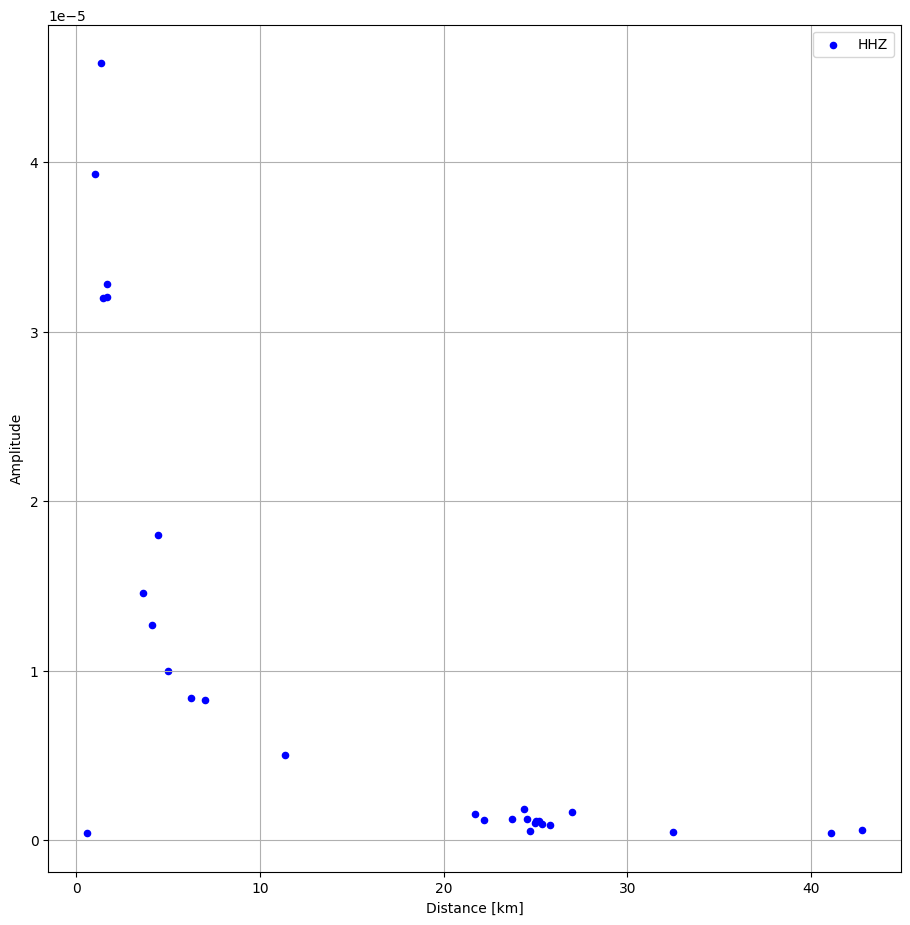

In [109]:
#SAVE FIGURE SWITCH
save_fig=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(1, 1, figsize=(11, 11), sharex=False)

# Plot per il primo subplot
axs.scatter(num.array(distance),
                num.array(hhe),
                label='HHE', s=20, color='green')
axs.scatter(num.array(distance),
                num.array(hhn),
                label='HHN', s=20, color='orange')
axs.scatter(num.array(distance),
                num.array(hhz),
                label='HHZ', s=20, color='blue')
axs.set_ylabel('Amplitude')
axs.grid(True)
axs.set_xlabel('Distance [km]')
axs.legend()

if save_fig:

    figname = os.path.join(plotdir, 'amplitude_vs_distance.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)

    figname_svg = os.path.join(plotdir, 'amplitude_vs_distance.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)